In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import model_settings as settings
from datetime import datetime
import os
import shutil
from lstm import LSTM_Model

In [3]:
tf.config.list_physical_devices('GPU')

2022-05-05 17:11:23.996225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:11:24.006071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:11:24.006664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Prepare training and validation dataset split

In [4]:
df_train = pd.read_csv(f"./data/{settings.DATASET}")
y = df_train.pop("y").values.astype('float32')
X = df_train[settings.COLUMNS_TO_USE].values.astype('float32')
del df_train

no_rows = X.shape[0]
data_valid = X[int(no_rows*0.8):,:]
y_valid = y[int(no_rows*0.8):]
data_train = X[:int(no_rows*0.8),:]
y_train = y[:int(no_rows*0.8)]

Reshaping X data to be on the correct form for input to a LSTM architecture: 
(batch_size, sequence_length, features)

In [5]:
from utils import reshape_for_LSTM

X_train = reshape_for_LSTM(data_train, settings.SEQUENCE_LENGTH)
y_train = y_train[settings.SEQUENCE_LENGTH:]
X_valid = reshape_for_LSTM(data_valid, settings.SEQUENCE_LENGTH)
y_valid = y_valid[settings.SEQUENCE_LENGTH:]

### Define model

In [6]:
model_name = datetime.now().strftime("%d_%m_%H_%M_%S")
model_name = "test"
lstm = LSTM_Model(model_name, settings)

2022-05-05 17:11:25.832629: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 17:11:25.833148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:11:25.833807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:11:25.834355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### Train model

Epoch 1/2


2022-05-05 17:11:30.902311: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200



Epoch 1: val_loss improved from inf to 0.00245, saving model to ./models/test/model.h5


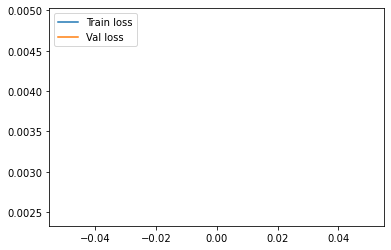

5608/5608 - 43s - loss: 0.0049 - val_loss: 0.0025 - 43s/epoch - 8ms/step
Epoch 2/2

Epoch 2: val_loss improved from 0.00245 to 0.00186, saving model to ./models/test/model.h5


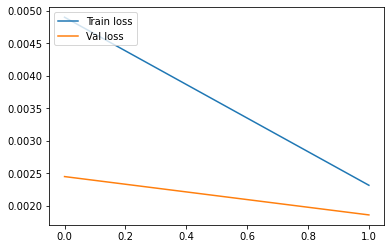

5608/5608 - 38s - loss: 0.0023 - val_loss: 0.0019 - 38s/epoch - 7ms/step


In [7]:
lstm.fit(X_train, y_train, X_valid, y_valid)

### Validate on training set

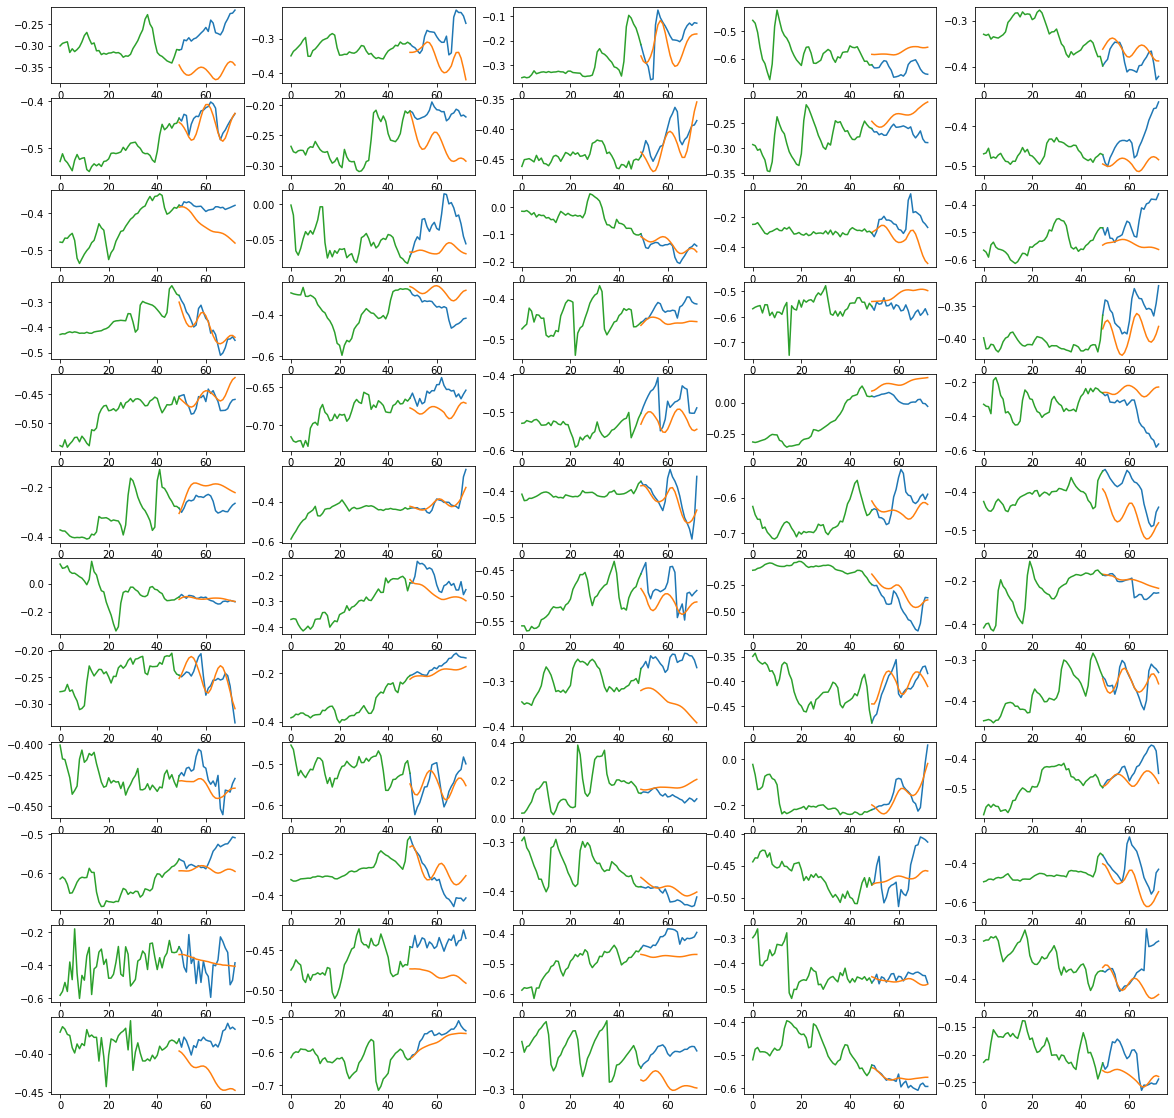

In [8]:
from utils import plot_random
plot_random(X, y, 60, lstm, f"./models/{model_name}/val_train.png")

# Validate on test set

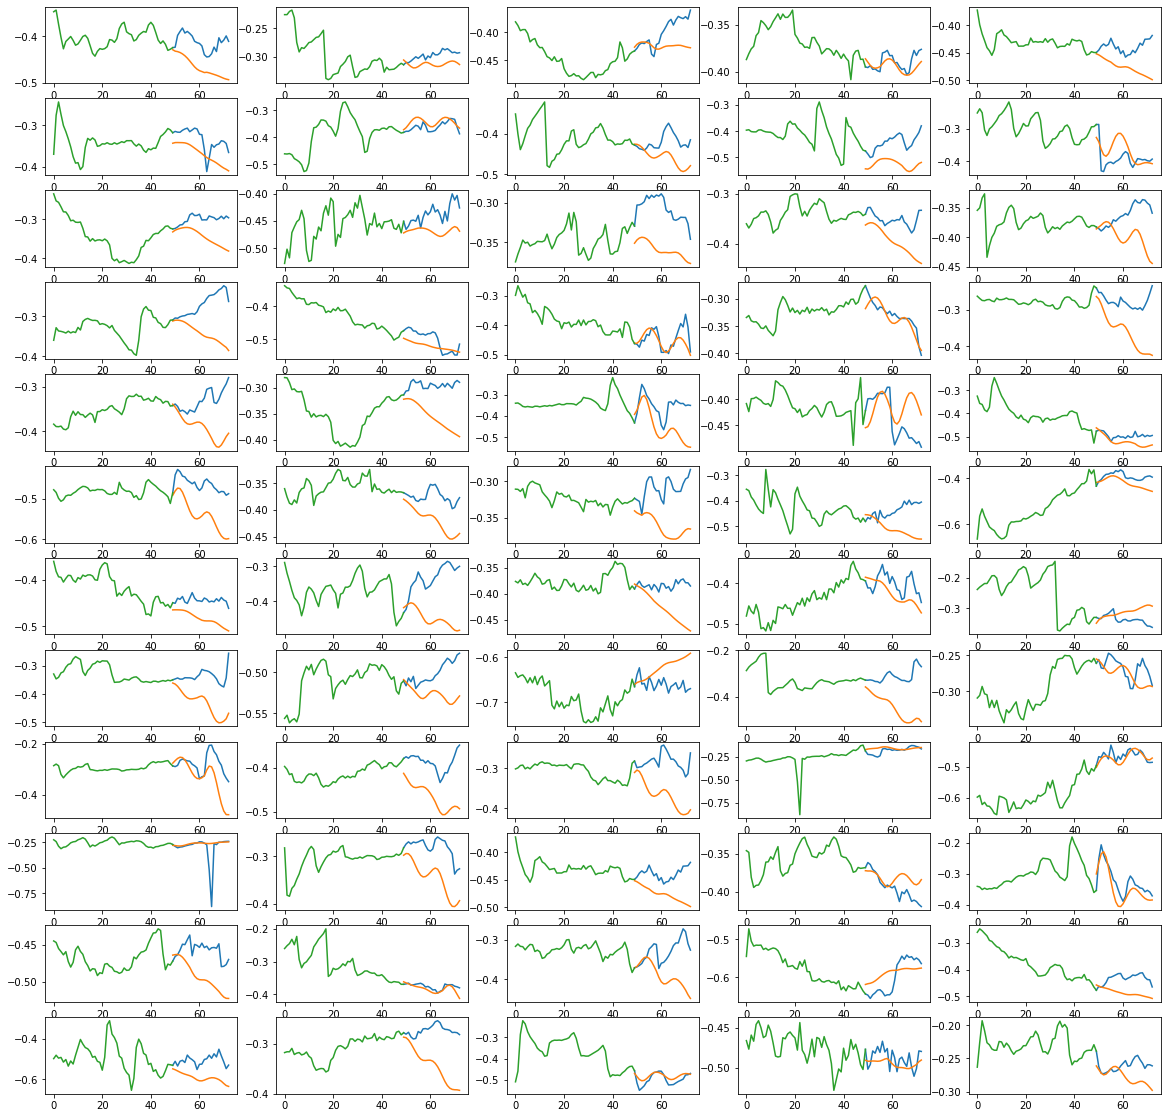

In [9]:
df = pd.read_csv(f"./data/{settings.TEST_DATASET}")
y = df.pop("y").values.astype('float32')
X = df[settings.COLUMNS_TO_USE].values.astype('float32')
plot_random(X, y, 60, lstm, f"./models/{model_name}/val_test.png")